<a href="https://colab.research.google.com/github/yichungcheng/GPT-Linebot-python-flask-on-vercel/blob/master/00_SSLMSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

安裝完成後，我們可以開始使用 `memory_profiler`。

要監控一個函式的記憶體使用量，只需在函式定義前加上 `@profile` 裝飾器。然後，執行您的程式碼，`memory_profiler` 會將記憶體使用報告列印到標準輸出。

**重要提示：**
*   `@profile` 裝飾器只在您使用 `python -m memory_profiler your_script.py` 執行腳本時生效。在 Colab 或 Jupyter 環境中，您需要結合 `%%writefile` 和 `!python -m memory_profiler` 來執行。
*   或者，您也可以使用 `mprof` 命令進行更詳細的分析，但這裡我會提供一個在 Colab 環境下直接顯示結果的範例。

**範例：監控兩個函式的記憶體使用量**

In [1]:
# # 1. 安裝 memory_profiler 函式庫
# !pip install -q memory_profiler

In [2]:
# from memory_profiler import profile
# import numpy as np

# # 將程式碼寫入一個臨時檔案，因為 @profile 裝飾器在 Colab 中直接使用需要額外步驟
# # 最簡單的方式是將要監控的程式碼寫入一個 .py 檔案，然後用 memory_profiler 模組執行

# %%writefile mem_test.py
# from memory_profiler import profile
# import numpy as np

# @profile
# def create_large_list():
#     a = [i * 2 for i in range(10**6)] # 建立一個包含一百萬個元素的列表
#     print(f"List created with {len(a)} elements")
#     return a

# @profile
# def create_large_array():
#     b = np.arange(10**7).reshape(1000, 10000) # 建立一個包含一千萬個元素的 numpy 陣列
#     print(f"Numpy array created with shape {b.shape}")
#     return b

# @profile
# def main():
#     print("Starting memory test...")
#     list_data = create_large_list()
#     array_data = create_large_array()
#     # 為了避免記憶體被立即釋放，我們在這裡做一些操作
#     _ = len(list_data)
#     _ = array_data.sum()
#     print("Memory test finished.")

# if __name__ == '__main__':
#     main()


# # 執行監控
# !python -m memory_profiler mem_test.py

# Self-supervised Learning for Endoscopic Video Analysis

In [3]:
# 1. 設置與安裝函式庫
!pip install -q torch torchvision
!pip install -q segmentation_models_pytorch
!pip install -q albumentations # 數據增強庫
!pip install -q pycocotools # 處理 COCO 格式的官方工具，用於解析多邊形
!pip install tensorflow

# 2. 匯入必要的函式庫
import os
import json
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO
from google.colab import drive
import shutil

# 3. 連接 Google Drive
drive.mount('/content/gdrive')

# 4. 定義路徑
# 您的資料夾名稱
DRIVE_DIR = '/content/gdrive/MyDrive/PMBM/論文程式/MSM'
# DATASET_NAME = 'Endoscope Spine Surgery.v12i.coco'
# UNZIP_PATH = '/content/dataset'


DATA_ROOT = DRIVE_DIR # 假設數據已經在 Drive 資料夾內

DRIVE_DIR = '/content/gdrive/MyDrive/PMBM/論文程式/MSM'
MODULE_DIR = os.path.join(DRIVE_DIR, 'ssl_msn')
os.makedirs(MODULE_DIR, exist_ok=True)
MODEL_SAVE_DIR = os.path.join(MODULE_DIR, 'models')
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)


# 檢查路徑結構
print(f"數據根目錄: {DATA_ROOT}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.0 MB/s eta 0:00:00
Mounted at /content/gdrive
數據根目錄: /content/gdrive/MyDrive/PMBM/論文程式/MSM


##### ssl_msn/
##### ├── main.py
##### ├── dataset.py
##### ├── augment.py
##### ├── model.py
##### ├── loss.py
##### └── train.py

dataset.py

In [4]:
# import tensorflow as tf
# import os

# IMG_SIZE = 224

# def parse_image(path):
#     img = tf.io.read_file(path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
#     img = tf.cast(img, tf.float32) / 255.0
#     return img

# def build_dataset(frames_root, batch_size):
#     """
#     frames_root/
#       ├── Video01/*.jpg
#       ├── Video02/*.jpg
#       └── ...
#     """

#     all_image_paths = []

#     # Iterate through each video directory from Video01 to Video80
#     for i in range(1, 81):
#         video_dir = os.path.join(frames_root, f"Video{i:02d}")
#         if not os.path.isdir(video_dir):
#             print(f"Warning: Video directory not found: {video_dir}")
#             continue

#         # List all image files within the current video directory
#         for filename in os.listdir(video_dir):
#             if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
#                 all_image_paths.append(os.path.join(video_dir, filename))

#     print(f"[INFO] Total frames loaded: {len(all_image_paths)}")

#     ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
#     ds = ds.shuffle(buffer_size=2048)

#     ds = ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
#     ds = ds.batch(batch_size)
#     ds = ds.prefetch(tf.data.AUTOTUNE)

#     return ds

三、Strong Augmentation（MSN 的靈魂）
augment.py四、MSN View Generator（same image → 2 views）

In [5]:
# import tensorflow as tf
# def strong_augment(x):
#     x = tf.image.random_flip_left_right(x)
#     x = tf.image.random_brightness(x, 0.4)
#     x = tf.image.random_contrast(x, 0.6, 1.4)
#     x = tf.image.random_saturation(x, 0.6, 1.4)

#     # random crop
#     crop_size = tf.random.uniform([], 180, 224, dtype=tf.int32)
#     x = tf.image.random_crop(x, size=[crop_size, crop_size, 3])
#     x = tf.image.resize(x, (224, 224))

#     return x
# def two_views(batch):
#     v1 = tf.map_fn(strong_augment, batch)
#     v2 = tf.map_fn(strong_augment, batch)
#     return v1, v2


五、Backbone + Projection Head
model.py

In [6]:
# !pip install tensorflow
# import tensorflow as tf
# from tensorflow.keras import layers, models
# def build_backbone():
#     base = tf.keras.applications.ResNet50(
#         include_top=False,
#         weights=None,
#         input_shape=(224, 224, 3),
#         pooling="avg"
#     )
#     return base
# def projection_head(dim=256):
#     return models.Sequential([
#         layers.Dense(1024, activation="gelu"),
#         layers.Dense(dim)
#     ])


六、MSN Loss（Student → Teacher distribution）
loss.py

In [7]:
# import tensorflow as tf
# def msn_loss(student, teacher, temperature=0.1):
#     student = tf.nn.log_softmax(student / temperature, axis=-1)
#     teacher = tf.nn.softmax(teacher / temperature, axis=-1)
#     return -tf.reduce_mean(tf.reduce_sum(teacher * student, axis=-1))


七、EMA Teacher Update（核心）

In [8]:
# def update_teacher(student, teacher, momentum=0.996):
#     for s, t in zip(student.trainable_variables,
#                     teacher.trainable_variables):
#         t.assign(momentum * t + (1.0 - momentum) * s)


八、Training Step（tf.function）
train.py

In [9]:
# This cell is now redundant as train_step is defined in train.py and imported by the main script.

九、Main（完整可跑）

In [10]:
import tensorflow as tf
import os
import sys
import importlib
import gc # Import garbage collector

DRIVE_DIR = '/content/gdrive/MyDrive/PMBM/論文程式/MSM'
MODULE_DIR = os.path.join(DRIVE_DIR, 'ssl_msn')
os.makedirs(MODULE_DIR, exist_ok=True)
MODEL_SAVE_DIR = os.path.join(MODULE_DIR, 'models')
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

DATA_ROOT = DRIVE_DIR # Explicitly define DATA_ROOT here

# Add MODULE_DIR to Python path to enable imports and give it priority
if MODULE_DIR not in sys.path:
    sys.path.insert(0, MODULE_DIR) # Use insert(0) for higher priority
    print(f"Added {MODULE_DIR} to sys.path: {sys.path}")
else:
    print(f"{MODULE_DIR} already in sys.path: {sys.path}")

# Write dataset.py
with open(os.path.join(MODULE_DIR, 'dataset.py'), 'w') as f:
    f.write('''import tensorflow as tf
import os

IMG_SIZE = 224

def parse_image(path):
    tf.print(f"Parsing image path: {path}, dtype: {path.dtype}") # Debug print
    img = tf.io.read_file(path)
    # \u8b80\u53d6jpg
    # img = tf.image.decode_jpeg(img, channels=3)
    # \u8b80\u53d6png
    img = tf.image.decode_png(img, channels=3) # Changed to decode_png
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img

def build_dataset(frames_root, batch_size, split_type=None):
    """
    frames_root/
      \u251c\u2500\u2500 Video01/*.jpg
      \u251c\u2500\u2500 Video02/*.jpg
      \u2514\u2500\u2500 ...
    """

    split_ranges = {
        'train': range(1, 2),
        'validation': range(2, 49),
        'test': range(49, 81)
    }

    all_image_paths = []

    if split_type and split_type in split_ranges:
        video_indices = split_ranges[split_type]
    else: # Default to all videos if split_type is not specified or invalid
        video_indices = range(1, 81)

    # Iterate through each video directory based on the split_type
    for i in video_indices:
        video_dir = os.path.join(frames_root, f"video{i:02d}")
        if not os.path.isdir(video_dir):
            print(f"Warning: video directory not found: {video_dir}")
            continue

        # List all image files within the current video directory
        for filename in os.listdir(video_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                all_image_paths.append(os.path.join(video_dir, filename))

    print(f"[INFO] Total frames loaded for {split_type or 'all'}: {len(all_image_paths)}")
    print(f"all_image_paths content before creating dataset: {all_image_paths[:5]} (first 5) and type: {type(all_image_paths[0]) if all_image_paths else 'empty'}")

    if not all_image_paths:
        print("No image paths found. Returning an empty dataset.")
        return tf.data.Dataset.from_tensor_slices(tf.constant([], dtype=tf.string))

    ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
    ds = ds.shuffle(buffer_size=2048)

    ds = ds.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds
''')

# Write augment.py
with open(os.path.join(MODULE_DIR, 'augment.py'), 'w') as f:
    f.write('''import tensorflow as tf
def strong_augment(x):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, 0.4)
    x = tf.image.random_contrast(x, 0.6, 1.4)
    x = tf.image.random_saturation(x, 0.6, 1.4)

    # random crop
    crop_size = tf.random.uniform([], 180, 224, dtype=tf.int32)
    x = tf.image.random_crop(x, size=[crop_size, crop_size, 3])
    x = tf.image.resize(x, (224, 224))

    return x
def two_views(batch):
    v1 = tf.map_fn(strong_augment, batch)
    v2 = tf.map_fn(strong_augment, batch)
    return v1, v2
''')

# Write model.py (Updated to Vision Transformer)
with open(os.path.join(MODULE_DIR, 'model.py'), 'w') as f:
    f.write('''import tensorflow as tf
from tensorflow.keras import layers, models

# ViT Parameters
PATCH_SIZE = 16
IMG_SIZE = 224 # Should match the IMG_SIZE in dataset.py
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 768 # Dimension for patch and positional embeddings
TRANSFORMER_LAYERS = 12 # Number of transformer blocks
NUM_HEADS = 12 # Number of attention heads
ATTENTION_DROPOUT = 0.0
PROJECTION_DROPOUT = 0.0

class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=tf.shape(patch)[1], delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches, "projection_dim": self.projection.units})
        return config

class TransformerBlock(layers.Layer):
    def __init__(self, projection_dim, num_heads, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate
        )
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp_dense1 = layers.Dense(projection_dim * 4, activation=tf.keras.activations.gelu)
        self.mlp_dense2 = layers.Dense(projection_dim, activation=tf.keras.activations.gelu)
        self.mlp_dropout = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        x = self.layernorm1(inputs)
        attn_output, attn_scores = self.mha(query=x, value=x, key=x, return_attention_scores=True, training=training)
        x = x + attn_output
        y = self.layernorm2(x)
        mlp_output = self.mlp_dense1(y)
        mlp_output = self.mlp_dense2(mlp_output)
        mlp_output = self.mlp_dropout(mlp_output, training=training)
        return x + mlp_output, attn_scores # Return attention scores here

    def get_config(self):
        config = super().get_config()
        config.update({"projection_dim": self.mha.key_dim, "num_heads": self.mha.num_heads, "dropout_rate": self.mha.dropout})
        return config

class ViTBackbone(models.Model):
    def __init__(self, input_shape, patch_size, projection_dim, num_heads, transformer_layers, dropout_rate, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.num_patches = (input_shape[0] // patch_size) ** 2

        self.patches = Patches(patch_size)
        # +1 for CLS token in num_patches for PatchEncoder's position embedding
        self.patch_encoder = PatchEncoder(self.num_patches + 1, projection_dim)
        self.transformer_blocks = []
        for i in range(transformer_layers):
            self.transformer_blocks.append(
                TransformerBlock(projection_dim, num_heads, dropout_rate, name=f"transformer_block_{i}")
            )
        self.layer_norm = layers.LayerNormalization(epsilon=1e-6)
        self.cls_token = self.add_weight(
            shape=(1, 1, projection_dim),
            initializer="zeros",
            trainable=True,
            name="cls_token_variable"
        )

    def call(self, inputs, return_attention=False, training=False):
        batch_size = tf.shape(inputs)[0]
        patches = self.patches(inputs)
        encoded_patches = self.patch_encoder(patches)

        cls_token_batch = tf.tile(self.cls_token, [batch_size, 1, 1])
        x = tf.concat([cls_token_batch, encoded_patches], axis=1)

        attention_scores_list = []
        for transformer_block in self.transformer_blocks:
            x, attn_scores = transformer_block(x, training=training)
            attention_scores_list.append(attn_scores)

        tokens = self.layer_norm(x)

        if return_attention:
            return tokens, attention_scores_list[-1] # Return last layer's attention
        return tokens # Default return if return_attention is False

    def get_config(self):
        config = super().get_config()
        config.update({
            "input_shape": (IMG_SIZE, IMG_SIZE, 3),
            "patch_size": self.patch_size,
            "projection_dim": self.projection_dim,
            "num_heads": self.transformer_blocks[0].mha.num_heads if self.transformer_blocks else 0,
            "transformer_layers": len(self.transformer_blocks),
            "dropout_rate": self.transformer_blocks[0].mha.dropout if self.transformer_blocks else 0.0
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Custom from_config to handle the cls_token_variable
        input_shape = config.pop('input_shape')
        instance = cls(input_shape=input_shape, **config)
        # The cls_token_variable will be created in __init__
        return instance

def build_backbone(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    return ViTBackbone(input_shape, PATCH_SIZE, PROJECTION_DIM, NUM_HEADS, TRANSFORMER_LAYERS, ATTENTION_DROPOUT)

def projection_head(dim=256):
    return models.Sequential([
        layers.Dense(1024, activation="gelu"),
        layers.Dense(dim)
    ])
''')

# Write loss.py
with open(os.path.join(MODULE_DIR, 'loss.py'), 'w') as f:
    f.write('''import tensorflow as tf
def msn_loss(student, teacher, temperature=0.1):
    student = tf.nn.log_softmax(student / temperature, axis=-1)
    teacher = tf.nn.softmax(teacher / temperature, axis=-1)
    return -tf.reduce_mean(tf.reduce_sum(teacher * student, axis=-1))
''')

# Write train.py - This needs to include update_teacher as well, and import msn_loss
with open(os.path.join(MODULE_DIR, 'train.py'), 'w') as f:
    f.write('''import tensorflow as tf
from loss import msn_loss # Now we can import it from the local file

def update_teacher(student, teacher, momentum=0.996):
    for s, t in zip(student.trainable_variables,
                    teacher.trainable_variables):
        t.assign(momentum * t + (1.0 - momentum) * s)

@tf.function
def train_step(view1, view2,
               student_backbone, teacher_backbone,
               student_head, teacher_head,
               optimizer):

    with tf.GradientTape() as tape:
        s_feat = student_backbone(view1, training=True)
        s_proj = student_head(s_feat, training=True)

        t_feat = teacher_backbone(view2, training=False)
        t_proj = teacher_head(t_feat, training=False)

        loss = msn_loss(s_proj, tf.stop_gradient(t_proj))

    vars = student_backbone.trainable_variables + student_head.trainable_variables
    grads = tape.gradient(loss, vars)
    optimizer.apply_gradients(zip(grads, vars))

    update_teacher(student_backbone, teacher_backbone)
    update_teacher(student_head, teacher_head)

    return loss
''')

print(f"Created module files in {MODULE_DIR} and added to Python path.")


# Now import from the created modules using import module and then module.func
import dataset
import augment
import model
import train

# Explicitly reload modules to ensure the latest version is used after writing files
importlib.reload(dataset)
importlib.reload(augment)
importlib.reload(model)
importlib.reload(train)

config_path = f'{DRIVE_DIR}/cholec80/config.json'
# Revert IMAGE_DIR to the previous value to verify its structure with ls
IMAGE_DIR = f"{DATA_ROOT}/cholec80/cholec80_extracted/frames"
BATCH_SIZE = 4 # Reduced batch size for lower RAM usage
EPOCHS = 2

print(f"Checking contents of DATA_ROOT/cholec80/cholec80_extracted: {DRIVE_DIR}/cholec80/cholec80_extracted/")
!ls -F "{DRIVE_DIR}/cholec80/cholec80_extracted/" # Inspect parent directory

print(f"Checking contents of IMAGE_DIR: {IMAGE_DIR}")
!ls -F "{IMAGE_DIR}" # Inspect IMAGE_DIR

# Call functions using the imported module prefix
train_dataset = dataset.build_dataset(IMAGE_DIR, BATCH_SIZE, split_type='train')

# Build ViT backbones
student_backbone = model.build_backbone()
teacher_backbone = model.build_backbone()
student_head = model.projection_head()
teacher_head = model.projection_head()

# initialize teacher
for s, t in zip(student_backbone.variables,
                    teacher_backbone.variables):
    t.assign(s)
for s, t in zip(student_head.variables, teacher_head.variables):
    t.assign(s)

optimizer = tf.keras.optimizers.Adam(1e-4)
print("training start")
for epoch in range(EPOCHS):
    total_loss = 0.0
    steps = 0

    for batch in train_dataset:
        v1, v2 = augment.two_views(batch)
        loss = train.train_step(
            v1, v2,
            student_backbone,
            teacher_backbone,
            student_head,
            teacher_head,
            optimizer
        )
        total_loss += loss
        steps += 1

    print(f"Epoch {epoch+1}: loss={total_loss/steps:.4f}")

# Save the student backbone model
student_backbone.save(f'{MODEL_SAVE_DIR}/msn_pretrained_backbone_vit.keras')

# Explicitly delete large objects to free up RAM
del train_dataset
del student_backbone
del teacher_backbone
del student_head
del teacher_head
del optimizer
import tensorflow.keras.backend as K
K.clear_session()
gc.collect()
print("Finished training and cleared memory.")

# 下面先不執行，移到獨立的block去執行
# # Update the visualization call to load from the TensorFlow SavedModel path
# image = f"{DATA_ROOT}/cholec80/cholec80_extracted/frames/video01/video01_000002.png"
# model_path_for_visualization = f'{MODEL_SAVE_DIR}/msn_pretrained_backbone_vit'
# # The visualize_vit_results function expects the model to be loaded before passing it if it's not a string.
# # So, let's load it here to pass the actual model object.
# loaded_vit_model = tf.keras.models.load_model(model_path_for_visualization, compile=False, custom_objects={
#     'Patches': model.Patches,
#     'PatchEncoder': model.PatchEncoder,
#     'TransformerBlock': model.TransformerBlock,
#     'ViTBackbone': model.ViTBackbone
# })
# visualize_vit_results(loaded_vit_model, image)


Added /content/gdrive/MyDrive/PMBM/論文程式/MSM/ssl_msn to sys.path: ['/content/gdrive/MyDrive/PMBM/論文程式/MSM/ssl_msn', '/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython', '/tmp/tmponmbut42']
Created module files in /content/gdrive/MyDrive/PMBM/論文程式/MSM/ssl_msn and added to Python path.
Checking contents of DATA_ROOT/cholec80/cholec80_extracted: /content/gdrive/MyDrive/PMBM/論文程式/MSM/cholec80/cholec80_extracted/
frames/  phase_annotations/  tool_annotations/
Checking contents of IMAGE_DIR: /content/gdrive/MyDrive/PMBM/論文程式/MSM/cholec80/cholec80_extracted/frames
video01/  video11/  video21/  video31/	video41/  video51/  video61/  video71/
video02/  video12/  video22/  video32/	video42/  video52/  video62/  video72/
video03/  video13/  video23/  video33/	video43/  video53/  vid

1️⃣ 原始手術影像
2️⃣ CLS Attention Map（最後一層）
3️⃣ Patch Similarity Map（cosine similarity）

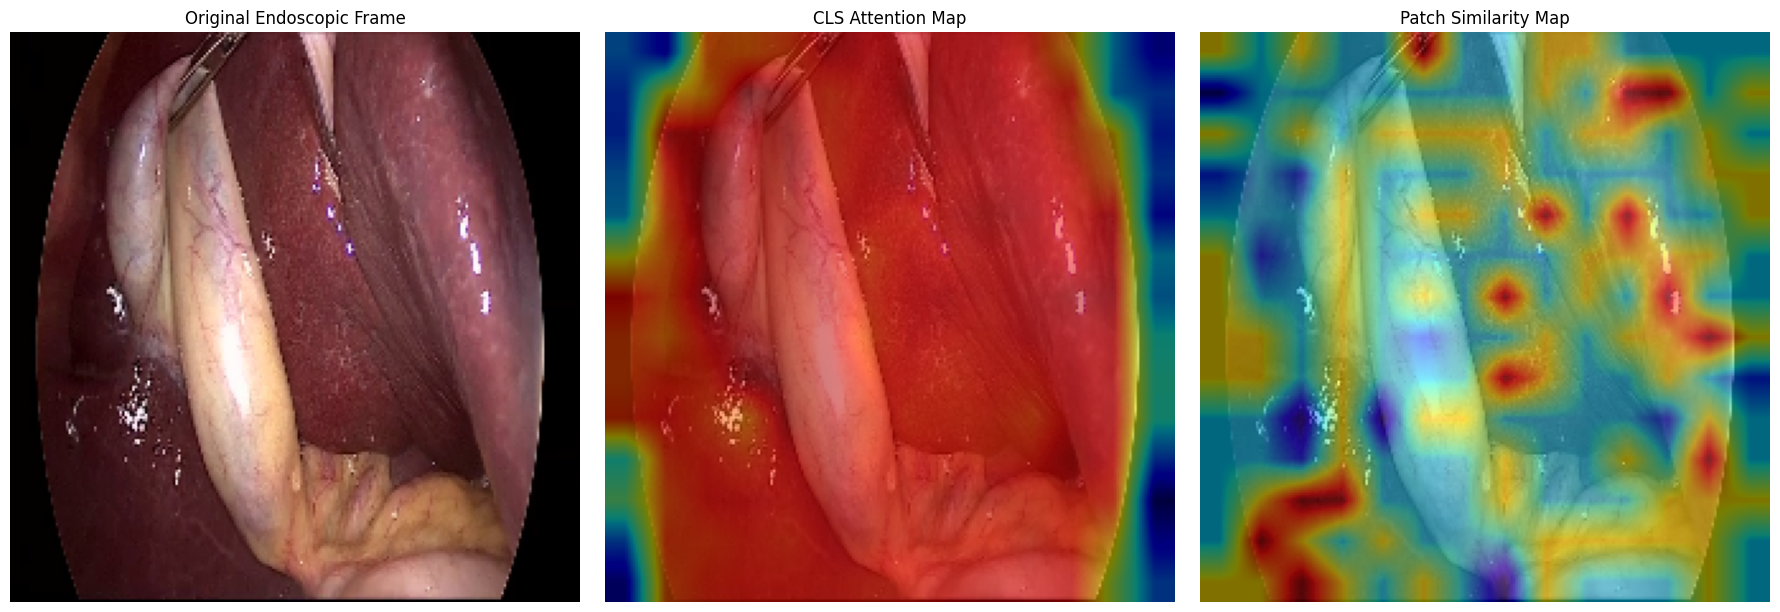

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Define paths for standalone execution of this cell
DRIVE_DIR = '/content/gdrive/MyDrive/PMBM/論文程式/MSM'
MODULE_DIR = os.path.join(DRIVE_DIR, 'ssl_msn')
MODEL_SAVE_DIR = os.path.join(MODULE_DIR, 'models')
DATA_ROOT = DRIVE_DIR # Explicitly define DATA_ROOT here

# ------------------------------------------------------------
# Main Visualization Function
# ------------------------------------------------------------
def visualize_vit_results(model, image):

    """
    model: ViT encoder (must return tokens + attention)
    image: single image tensor (H, W, 3), normalized 0~1, or image path
    """

    # 2026/02/15 add for image path
    if isinstance(model, str):
      # When loading from a string path, ensure custom_objects are provided
      # Assuming 'model' module is available in the current scope for custom objects
      import model as model_module # Renamed to avoid conflict with 'model' parameter
      model = tf.keras.models.load_model(model, compile=False, custom_objects={
          'Patches': model_module.Patches,
          'PatchEncoder': model_module.PatchEncoder,
          'TransformerBlock': model_module.TransformerBlock,
          'ViTBackbone': model_module.ViTBackbone
      })

    if isinstance(image, str):
        image = tf.io.read_file(image)
        image = tf.image.decode_image(image, channels=3, expand_animations=False)
        image = tf.image.convert_image_dtype(image, tf.float32)
        # Add resizing here to match model input shape
        image = tf.image.resize(image, (224, 224))

    # Expand batch
    input_tensor = tf.expand_dims(image, 0)


    # Forward
    tokens, attn = model(input_tensor, return_attention=True)

    tokens = tokens[0]           # (N, D)
    attn = attn[0]               # (heads, N, N)

    # --------------------------------------------------------
    # 1️⃣ Original Image
    # --------------------------------------------------------
    original_img = image.numpy()

    # --------------------------------------------------------
    # 2️⃣ Attention Map (CLS → patches)
    # --------------------------------------------------------
    # Average over heads
    attn_mean = tf.reduce_mean(attn, axis=0)  # (N, N)

    cls_attn = attn_mean[0, 1:]  # CLS token attention to patches

    num_patches = int(np.sqrt(len(cls_attn)))
    cls_attn_map = tf.reshape(cls_attn, (num_patches, num_patches))

    cls_attn_map = cls_attn_map.numpy()

    # Normalize for visualization
    cls_attn_map = (cls_attn_map - cls_attn_map.min()) / \
                   (cls_attn_map.max() - cls_attn_map.min() + 1e-8)

    # Resize to image size
    cls_attn_map = tf.image.resize(
        cls_attn_map[..., None],
        (original_img.shape[0], original_img.shape[1])
    ).numpy().squeeze()

    # --------------------------------------------------------
    # 3️⃣ Similarity Map
    # --------------------------------------------------------
    # Remove CLS token
    patch_tokens = tokens[1:]  # (N-1, D)

    # Choose reference patch (center patch)
    ref_idx = len(patch_tokens) // 2
    ref_token = patch_tokens[ref_idx]

    # Cosine similarity
    patch_tokens_norm = tf.math.l2_normalize(patch_tokens, axis=1)
    ref_token_norm = tf.math.l2_normalize(ref_token, axis=0)

    similarity = tf.matmul(
        patch_tokens_norm,
        tf.expand_dims(ref_token_norm, -1)
    )

    similarity = tf.squeeze(similarity)

    similarity_map = tf.reshape(
        similarity,
        (num_patches, num_patches)
    ).numpy()

    # Normalize
    similarity_map = (similarity_map - similarity_map.min()) / \
                     (similarity_map.max() - similarity_map.min() + 1e-8)

    similarity_map = tf.image.resize(
        similarity_map[..., None],
        (original_img.shape[0], original_img.shape[1])
    ).numpy().squeeze()

    # --------------------------------------------------------
    # Plot 3 images side-by-side
    # --------------------------------------------------------
    plt.figure(figsize=(18, 6))

    # 1‼️ Original
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original Endoscopic Frame")
    plt.axis("off")

    # 2‼️ Attention
    plt.subplot(1, 3, 2)
    plt.imshow(original_img)
    plt.imshow(cls_attn_map, cmap="jet", alpha=0.5)
    plt.title("CLS Attention Map")
    plt.axis("off")

    # 3‼️ Similarity
    plt.subplot(1, 3, 3)
    plt.imshow(original_img)
    plt.imshow(similarity_map, cmap="jet", alpha=0.5)
    plt.title("Patch Similarity Map")
    plt.axis("off")

    plt.tight_layout()
    plt.show()



# 假設你已經有:
# model = pretrained_vit_encoder
# image = dataset.take(1) 取出的單張圖
image= f"{DATA_ROOT}/cholec80/cholec80_extracted/frames/video01/video01_000002.png"
# Correct the model path to point to the SavedModel directory, not a .keras file
model = f'{MODEL_SAVE_DIR}/msn_pretrained_backbone_vit.keras'
visualize_vit_results(model, image)
